# Modelo XGBoost

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import os

In [2]:
SEED = 42
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [3]:
# Eliminar CATEGORIA = 2
df_filtrado = df[df['CATEGORIA'] != 2].copy()

# Remapear categorías a consecutivas 0..K-1
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Definir modelo XGBoost

### Division de data test y prueba

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

### Entrenamiento

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# --- ajusta esto si tienes CUDA y xgboost con soporte GPU ---
use_gpu = False  # True si quieres intentar GPU

# === Grid de hiperparámetros XGBoost ===
n_estimators_list   = [100, 200]
max_depth_list      = [4, 6]
learning_rate_list  = [0.05, 0.1]
subsample_list      = [0.8, 1.0]
colsample_bytree_list = [0.8, 1.0]

mejor_cfg = None
mejor_f1  = -1.0
mejor_xgb = None
mejor_grich = None
grich_n = 0

for n_est, md, lr, subs, colsb in itertools.product(
        n_estimators_list, max_depth_list, learning_rate_list, subsample_list, colsample_bytree_list):

    grich_n += 1
    cfg = dict(n_estimators=n_est, max_depth=md, learning_rate=lr, subsample=subs, colsample_bytree=colsb)
    print(f"XGB Grid {grich_n}: {cfg}")

    xgb = XGBClassifier(
        n_estimators=n_est,
        max_depth=md,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=colsb,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="gpu_hist" if use_gpu else "hist",
        n_jobs=-1,
        random_state=42
    )

    # --- Entrenamiento cronometrado ---
    t0_fit = time.perf_counter()
    xgb.fit(X_train, y_train, verbose=False)
    fit_s = time.perf_counter() - t0_fit

    # --- Predicción cronometrada ---
    t0_pred = time.perf_counter()
    y_pred = xgb.predict(X_test)
    pred_s = time.perf_counter() - t0_pred
    ms_per_sample = (pred_s / len(y_test)) * 1000.0

    # --- Métricas ---
    oa = accuracy_score(y_test, y_pred)
    prec, rec, f1m, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    cm = confusion_matrix(y_test, y_pred)
    cm_row_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100.0
    cm_row_percentage = np.nan_to_num(cm_row_percentage)
    rpt_x_class = classification_report(y_test, y_pred, digits=3)

    print(f"⏱ Train: {fit_s:.2f}s | Test: {pred_s:.3f}s  ({ms_per_sample:.2f} ms/muestra)")
    print(f"OA: {oa:.4f} | Prec(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1-macro: {f1m:.4f}")
    print("-" * 80)

    # --- Guardar mejor por F1-macro ---
    if f1m > mejor_f1:
        mejor_f1   = f1m
        mejor_cfg  = cfg.copy()
        mejor_xgb  = xgb
        mejor_grich = grich_n
        mejor_pred_s = pred_s
        mejor_fit_s  = fit_s
        mejor_oa, mejor_prec, mejor_rec, mejor_f1m = oa, prec, rec, f1m
        mejor_cm, mejor_cm_per = cm, cm_row_percentage
        mejor_rpt = rpt_x_class

XGB Grid 1: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
⏱ Train: 0.40s | Test: 0.004s  (0.00 ms/muestra)
OA: 0.8739 | Prec(macro): 0.8316 | Recall(macro): 0.7862 | F1-macro: 0.8065
--------------------------------------------------------------------------------
XGB Grid 2: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0}
⏱ Train: 0.31s | Test: 0.005s  (0.00 ms/muestra)
OA: 0.8733 | Prec(macro): 0.8297 | Recall(macro): 0.7865 | F1-macro: 0.8057
--------------------------------------------------------------------------------
XGB Grid 3: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8}
⏱ Train: 0.29s | Test: 0.003s  (0.00 ms/muestra)
OA: 0.8721 | Prec(macro): 0.8286 | Recall(macro): 0.7831 | F1-macro: 0.8031
--------------------------------------------------------------------------------
XGB Grid 4: {'n_estimators': 100, 

Mejor configuración Grid 29: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8} | F1-macro: 0.8289
⏱ Train: 0.86s | Test: 0.008s  (0.00 ms/muestra)
OA: 0.8870 | Prec(macro): 0.8463 | Recall(macro): 0.8133 | F1-macro: 0.8289

Reporte por clase:
               precision    recall  f1-score   support

           0     0.9033    0.9081    0.9057      2459
           1     0.9122    0.9324    0.9222      4568
           2     0.9664    0.9405    0.9532       336
           3     0.8426    0.7712    0.8053       354
           4     0.7663    0.6845    0.7231       412
           5     0.6733    0.6403    0.6564       631

    accuracy                         0.8866      8760
   macro avg     0.8440    0.8128    0.8276      8760
weighted avg     0.8849    0.8866    0.8855      8760



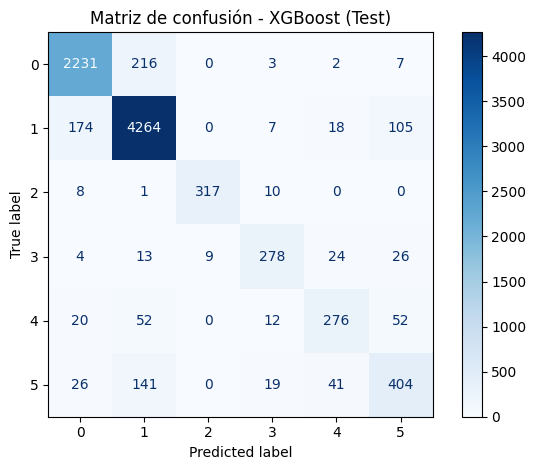

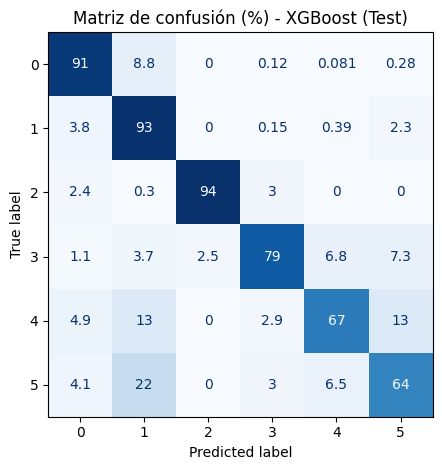

In [6]:
# --- Resultados finales ---
print(f"Mejor configuración Grid {mejor_grich}: {mejor_cfg} | F1-macro: {mejor_f1:.4f}")
print(f"⏱ Train: {mejor_fit_s:.2f}s | Test: {mejor_pred_s:.3f}s  ({(mejor_pred_s/len(y_test))*1000:.2f} ms/muestra)")
print(f"OA: {mejor_oa:.4f} | Prec(macro): {mejor_prec:.4f} | Recall(macro): {mejor_rec:.4f} | F1-macro: {mejor_f1m:.4f}")
print("\nReporte por clase:\n", classification_report(y_test, y_pred, digits=4))

# Matriz de confusión (conteos)
ConfusionMatrixDisplay(mejor_cm).plot(cmap='Blues')
plt.title("Matriz de confusión - XGBoost (Test)")
plt.tight_layout(); plt.show()

# Matriz de confusión en porcentaje por fila
ConfusionMatrixDisplay(mejor_cm_per).plot(cmap='Blues', colorbar=False)
plt.title("Matriz de confusión (%) - XGBoost (Test)")
plt.tight_layout(); plt.show()
